In [13]:
#!pip install lime
#!pip install captum
from captum.attr import visualization as viz
from captum.attr import GuidedGradCam
import torch.nn as nn
import numpy as np
import torch
from torchvision import transforms
from medmnist import DermaMNIST
import matplotlib.pyplot as plt

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.42506683639262255)

        # Oblicz rozmiar spłaszczonego tensora
        self.flattened_size = self.get_flattened_size((3, 64, 64))
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # 7 klas w DermaMNIST

    def get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = CNN()
model.load_state_dict(torch.load("best_model_optuna_best_adam_more_tran_conv.pth"))
model.eval()  # Ustaw model w tryb ewaluacji
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout):

Using downloaded and verified file: C:\Users\Kamil\.medmnist\dermamnist_64.npz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.098992..1.0].


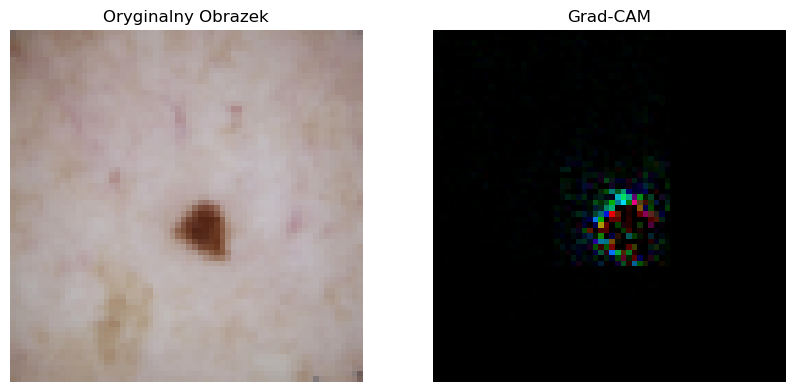

In [14]:
# Funkcja do wyświetlania obrazków
def show_images(original_image, gradcam_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Oryginalny Obrazek")
    ax[0].axis("off")
    ax[1].imshow(gradcam_image, cmap="jet")
    ax[1].set_title("Grad-CAM")
    ax[1].axis("off")
    plt.show()

# Transformacje dla obrazu testowego
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Funkcja do pobrania obrazu z zestawu testowego
def get_test_image(index):
    dataset = DermaMNIST(split="test", download=True, transform=transform, size=64)
    return dataset[index]

# Pobranie przykładowego obrazu z zestawu testowego
index = 2004 # Możesz zmienić ten indeks, aby wybrać inne zdjęcie
test_image, test_label = get_test_image(index)

# Konwersja obrazu na tensor z wymiarem batch (B, C, H, W)
test_image = test_image.unsqueeze(0)

# Ustawienie urządzenia (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Przeniesienie modelu i obrazu na to samo urządzenie
model = CNN()
model.load_state_dict(torch.load("best_model_optuna_best_adam_more_tran_conv.pth"))
#model.load_state_dict(torch.load("best_model_optuna_best_adamW_more_tran_conv.pth"))
#model.load_state_dict(torch.load("best_model_optuna_best_sgd_more_tran_conv.pth"))
model.eval()  # Ustaw model w tryb ewaluacji
model = model.to(device)
test_image = test_image.to(device)

# 3. Guided Grad-CAM Explanation
layer = model.conv5  # Ostatnia warstwa konwolucyjna modelu

# Tworzenie obiektu Guided Grad-CAM
gradcam = GuidedGradCam(model, layer)

# Forward pass i wybór klasy docelowej
output = model(test_image)  # Forward pass
target_class = torch.argmax(output).item()

# Grad-CAM atrybucje
attributions = gradcam.attribute(test_image, target=target_class)

# Normalizacja atrybucji
attributions = attributions / torch.max(attributions)

# Konwersja tensora do formatu NumPy dla wizualizacji
test_image_np = (test_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy() * 0.5) + 0.5

# Wizualizacja Grad-CAM
gradcam_image = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Wyświetlanie obrazków
show_images(test_image_np, gradcam_image)

Using downloaded and verified file: C:\Users\Kamil\.medmnist\dermamnist_64.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.8745098].


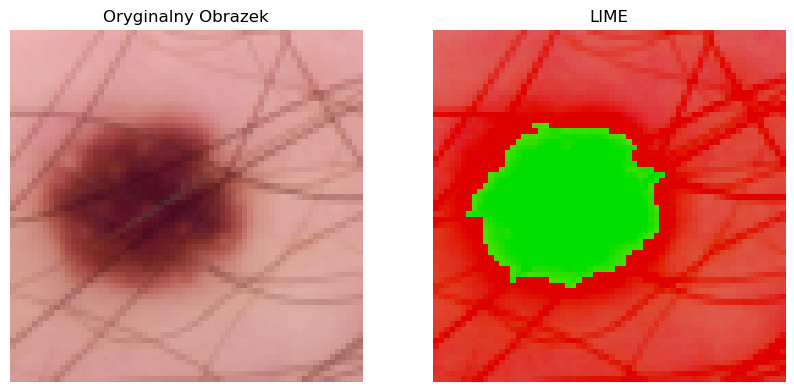

In [17]:
from lime import lime_image
# Funkcja do wyświetlania obrazków
def show_images(original_image, lime_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Oryginalny Obrazek")
    ax[0].axis("off")
    ax[1].imshow(lime_image)
    ax[1].set_title("LIME")
    ax[1].axis("off")
    plt.show()

# Transformacje dla obrazu testowego
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Funkcja do pobrania obrazu z zestawu testowego
def get_test_image(index):
    dataset = DermaMNIST(split="test", download=True, transform=transform, size=64)
    return dataset[index]

# Pobranie przykładowego obrazu z zestawu testowego
index = 0  # Możesz zmienić ten indeks, aby wybrać inne zdjęcie
test_image, test_label = get_test_image(index)

# Konwersja obrazu na tensor z wymiarem batch (B, C, H, W)
test_image = test_image.unsqueeze(0)

# Ustawienie urządzenia (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Przeniesienie modelu i obrazu na to samo urządzenie
model = CNN()
#model.load_state_dict(torch.load("best_model_optuna_best_adam_more_tran_conv.pth"))
model.load_state_dict(torch.load("best_model_optuna_best_adamW_more_tran_conv.pth"))
#model.load_state_dict(torch.load("best_model_optuna_best_sgd_more_tran_conv.pth"))
model.eval()  # Ustaw model w tryb ewaluacji
model = model.to(device)
test_image = test_image.to(device)

# Tworzenie obiektu LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Funkcja predykcyjna dla Lime
def predict_fn(images):
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    images = images.to(device)
    outputs = model(images)
    return outputs.detach().cpu().numpy()

# Wyjaśnienie predykcji za pomocą Lime
explanation = explainer.explain_instance(test_image.squeeze(0).permute(1, 2, 0).cpu().numpy(), 
                                         predict_fn, 
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

# Pobranie maski i segmentacji
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Wizualizacja Lime
lime_image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=5
)

# Konwersja tensora do formatu NumPy dla wizualizacji
test_image_np = (test_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy() * 0.5) + 0.5

# Wyświetlanie obrazków
show_images(test_image_np, lime_image)